# Pronósticos, Round 2 - Parte 2: Otros Metódos Estadísticos

## 1. Introducción

Ah, el futuro... la última frontera. Ah no... eso fue en la [primera parte](https://gonzalezhomar.netlify.app/post/pronr2_1sarimax/). En mi anterior entrega, ya plantee el problema, expuse las series que voy a analizar, y por qué fue necesario dividirlas en un grupo de series mensuales y un grupo de series trimestrales. También realicé ese primer análisis con la [metodología Box-Jenkins](https://es.wikipedia.org/wiki/Metodología_de_Box-Jenkins) para modelos SARIMAX.

Si bien estos módelos son una de las principales herramientas para hacer estimaciones de series de tiempo, existen otros métodos estadísticos con los que se pueden hacer pronósticos de series de tiempo. Para esta entrada decidí experimentar con los modelos de suavizamiento exponencial y en particular con el módelo Holt Winters. En esta ocasión me inspiré en [esta publicación de Medium](https://towardsdatascience.com/time-series-forecasting-with-statistical-models-in-python-code-da457a46d68a).

La *notebook* con el código completo de esta publicación se puede encontrar en mi repositorio de [Github](https://github.com/gonzalezhomar/articulos_pronosticos) o la pueden ver directamente [aquí](https://nbviewer.jupyter.org/github/gonzalezhomar/articulos_pronosticos/blob/main/PronR2_2.ipynb).

## 2. Holt-Winters

El metodo Holt-Winters se basa en una típica descomposición de la serie de tiempo, donde se le asigna mayor peso a las observaciones más recientes. La descomposición de este método puede ser lineal (la serie se descompone en partes que se suman) o multiplicativa (la serie se descompone en variables que se multiplican), pero en ambos casos utiliza los siguientes componentes: una parte de nivel, una parte de tendencia, una parte estacionaria y el error.

A diferencia del método SARIMAX que utilicé en la primera parte, este método se encuentra implementado en el paquete *statsmodels* casi de manera directa. Si bien tuve una pequeña complicación más adelante, preferí dejarla de lado y solucionarlo en otro momento, con el objetivo de concluir esta sección en menor tiempo.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
df = pd.read_csv('202107mensuales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

,ano,mes,dia,fechas,ieps_gas,ieps_tabacos,ieps_bebidas,ieps_cervezas,ieps_bebidassab,ieps_alimentos,importacion,rfp_petroleros,fecha
fecha,,,,,,,,,,,,,
2022-08-01,2022,8,1,ago-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-01
2022-09-01,2022,9,1,sep-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-01
2022-10-01,2022,10,1,oct-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-01
2022-11-01,2022,11,1,nov-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-11-01
2022-12-01,2022,12,1,dic-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-12-01


# 3. Series Mensuales

Al igual que en la primera parte, analizaré por separado las series mensuales de las series trimestrales. Presentaré el análisis más completo en la primer serie y en las que siguen solo dejaré los resultados. Como se verá este camino es mucho más sencillo, por lo que resulta casi inmediato.

### 3.1 IEPS Cervezas

Como señale antes, una descomposición de series de tiempo puede ser lineal (la serie se descompone en partes que se suman) o multiplicativa (la serie se descompone en variables que se multiplican). La descomposición lineal de la serie de IEPS cervezas es la siguiente:

In [3]:
ieps_cervezasp=df['ieps_cervezas']
ieps_cervezas=ieps_cervezasp.dropna()
ieps_cervezas.head()

fecha
2002-01-01     785.9
2002-02-01    1152.3
2002-03-01     540.0
2002-04-01     702.0
2002-05-01     826.0
Name: ieps_cervezas, dtype: float64

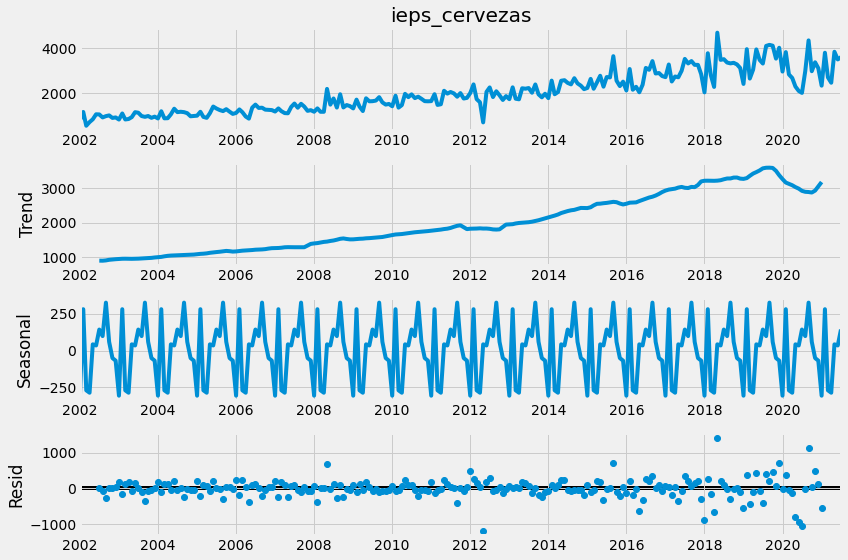

In [4]:
decomposition = seasonal_decompose(ieps_cervezas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

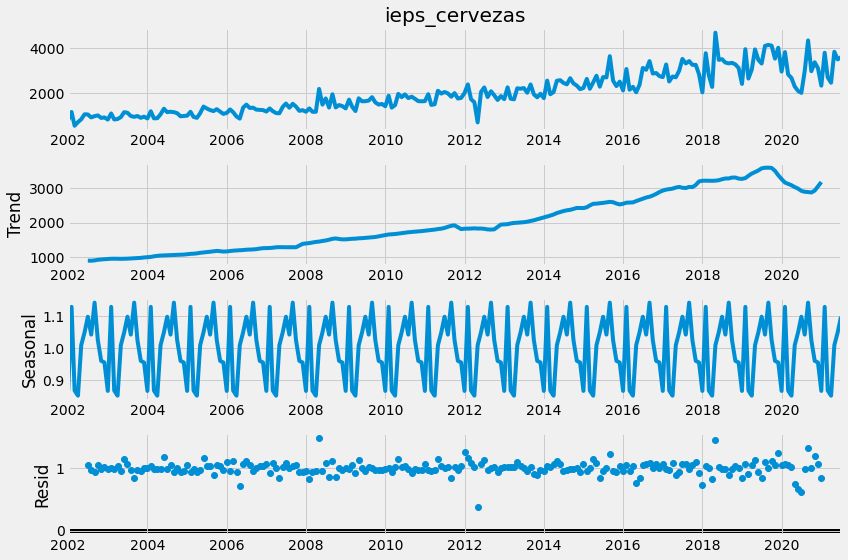

In [5]:
decomposition = seasonal_decompose(ieps_cervezas, freq=12, model='multiplicative')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

Text(0.5, 1.0, 'IEPS Cervezas')

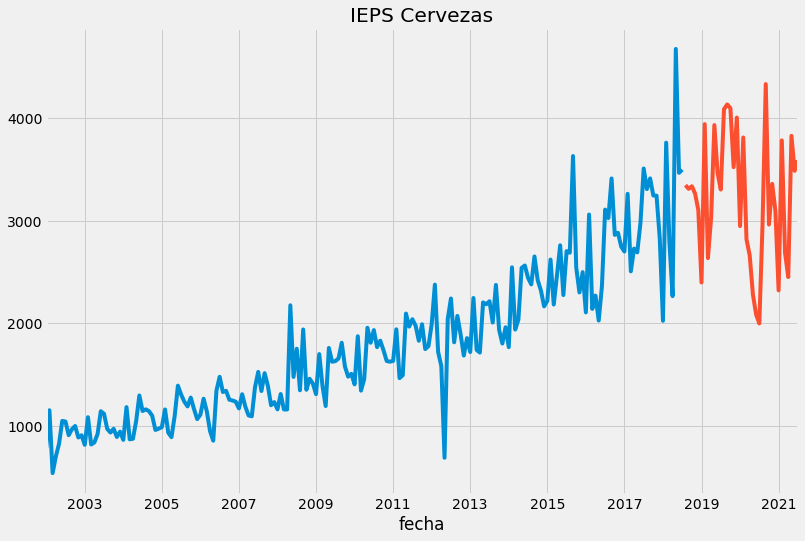

In [6]:
#divide into train and validation set
train = ieps_cervezas[:int(0.85*(len(ieps_cervezas)))]
test = ieps_cervezas[int(0.85*(len(ieps_cervezas))):]
#plotting the data
train.plot()
test.plot()
plt.title('IEPS Cervezas')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


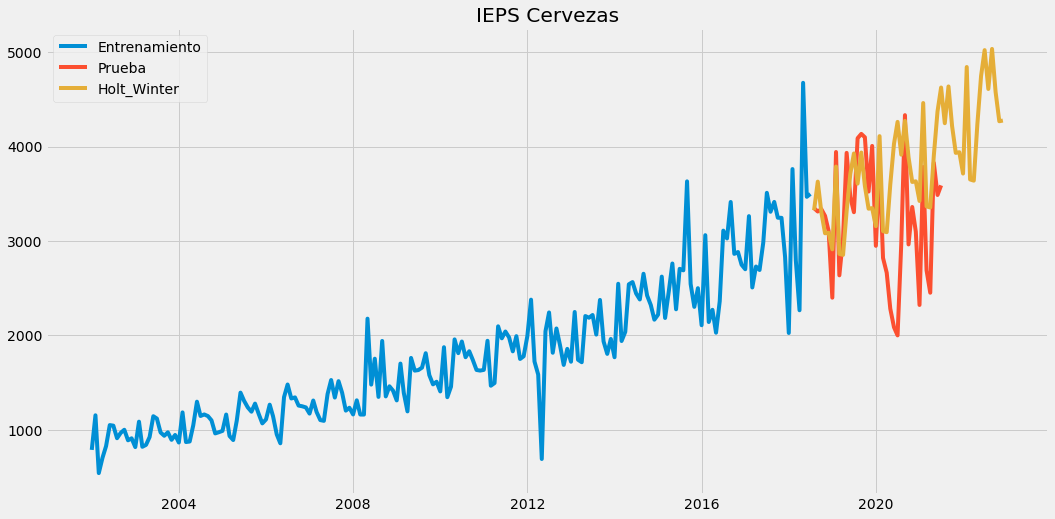

In [7]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter1 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter1, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IEPS Cervezas')
plt.show()

### 3.2 IEPS Gasolinas

Text(0.5, 1.0, 'IEPS Gasolinas')

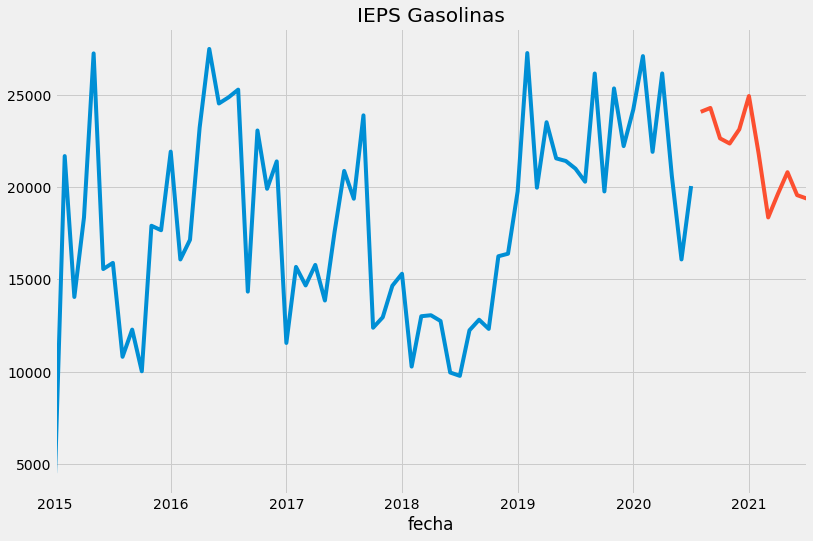

In [8]:
ieps_gasp=df['ieps_gas']
ieps_gas=ieps_gasp.dropna()
train = ieps_gas[:int(0.85*(len(ieps_gas)))]
test = ieps_gas[int(0.85*(len(ieps_gas))):]
#plotting the data
train.plot()
test.plot()
plt.title('IEPS Gasolinas')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


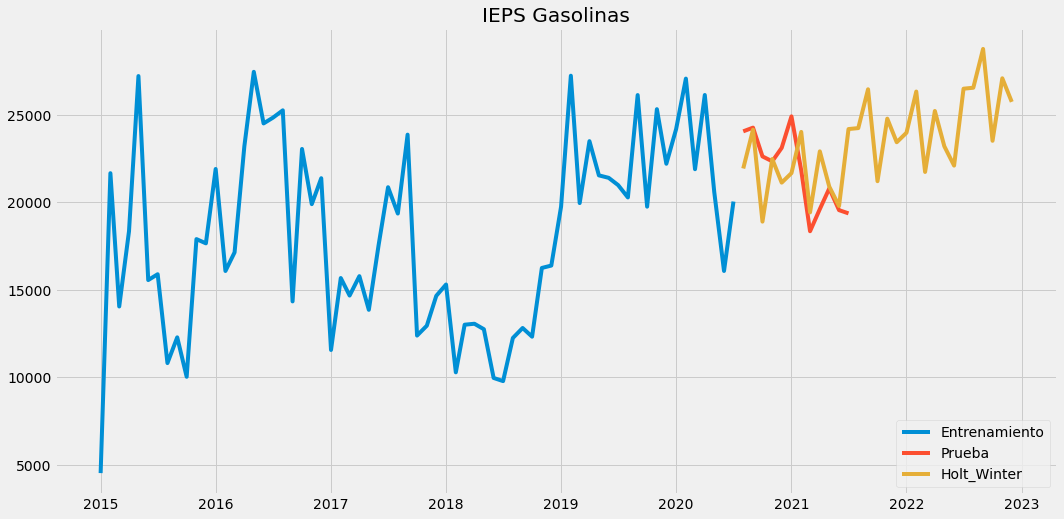

In [9]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter2 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter2, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IEPS Gasolinas')
plt.show()

### 3.3 IEPS Bebidas

Text(0.5, 1.0, 'IEPS Bebidas')

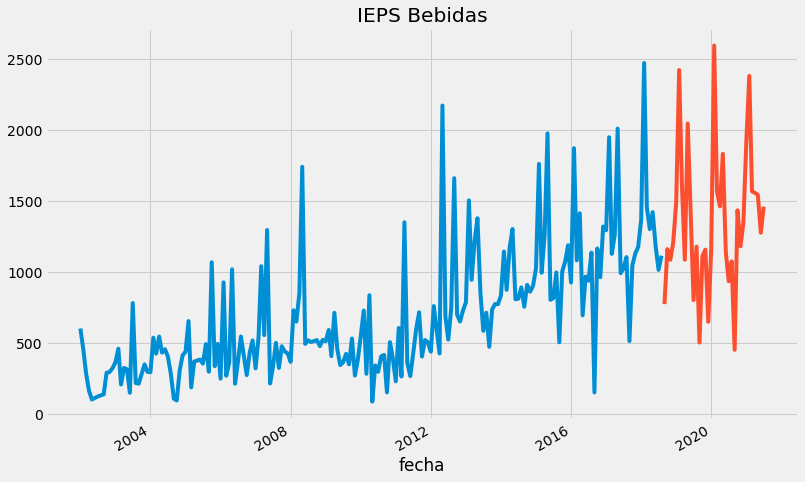

In [10]:
ieps_bebidasp=df['ieps_bebidas']
ieps_bebidas=ieps_bebidasp.dropna()
ieps_bebidas = ieps_bebidas[(ieps_bebidas>0)]
train = ieps_bebidas[:int(0.85*(len(ieps_bebidas)))]
test = ieps_bebidas[int(0.85*(len(ieps_bebidas))):]
#plotting the data
train.plot()
test.plot()
plt.title('IEPS Bebidas')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


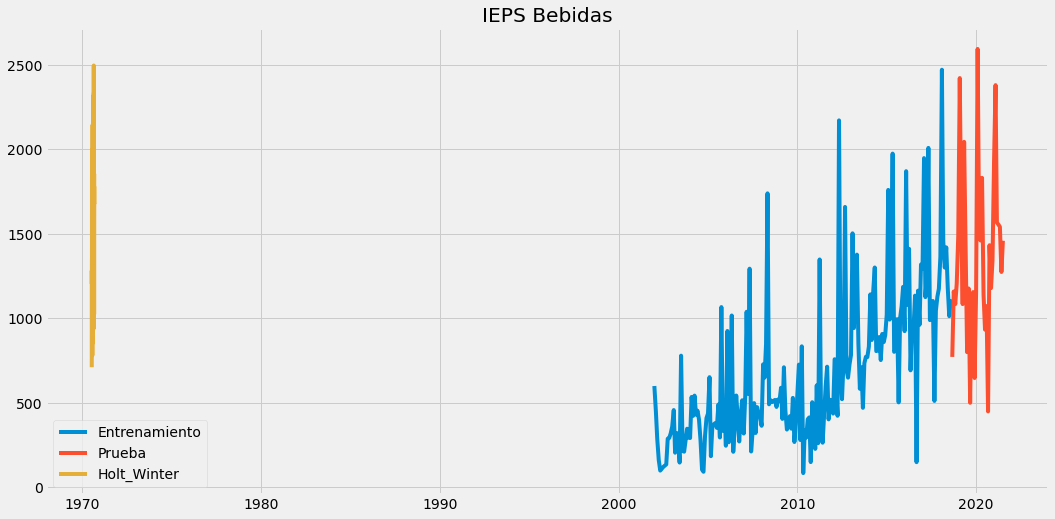

In [11]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter3 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter3, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IEPS Bebidas')
plt.show()

### 3.4 IEPS Tabacos

Text(0.5, 1.0, 'IEPS Tabacos')

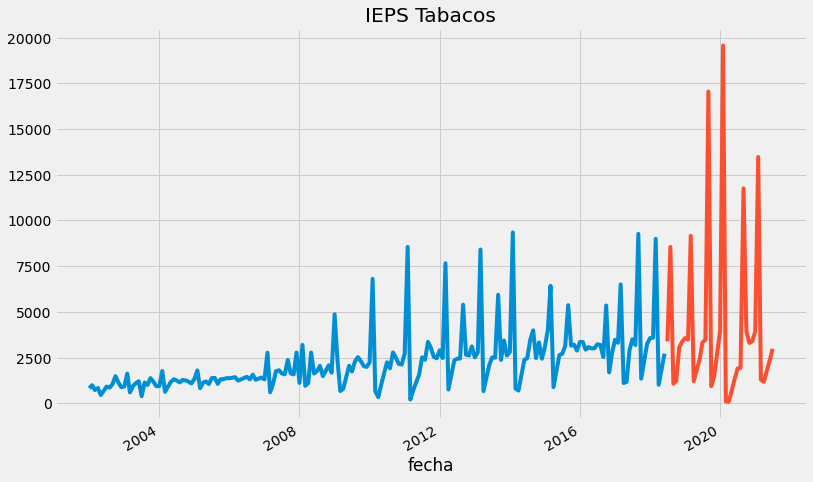

In [12]:
ieps_tabacosp=df['ieps_tabacos']
ieps_tabacos=ieps_tabacosp.dropna()
ieps_tabacos = ieps_tabacos[(ieps_tabacos>0)]
train = ieps_tabacos[:int(0.85*(len(ieps_tabacos)))]
test = ieps_tabacos[int(0.85*(len(ieps_tabacos))):]
#plotting the data
train.plot()
test.plot()
plt.title('IEPS Tabacos')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


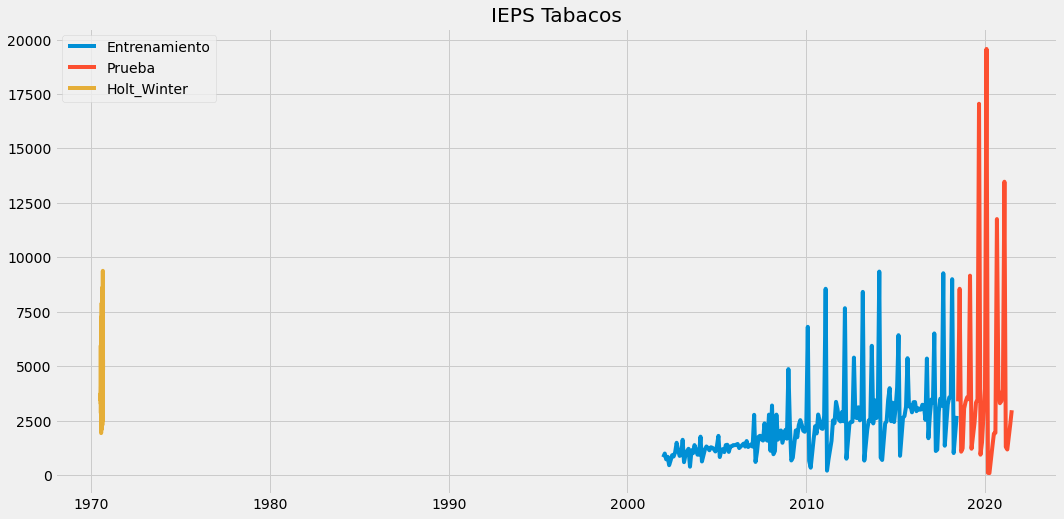

In [13]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter4 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter4, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IEPS Tabacos')
plt.show()

### 3.5 IEPS Bebidas Saborizadas

Text(0.5, 1.0, 'IEPS Bebidas Saborizadas')

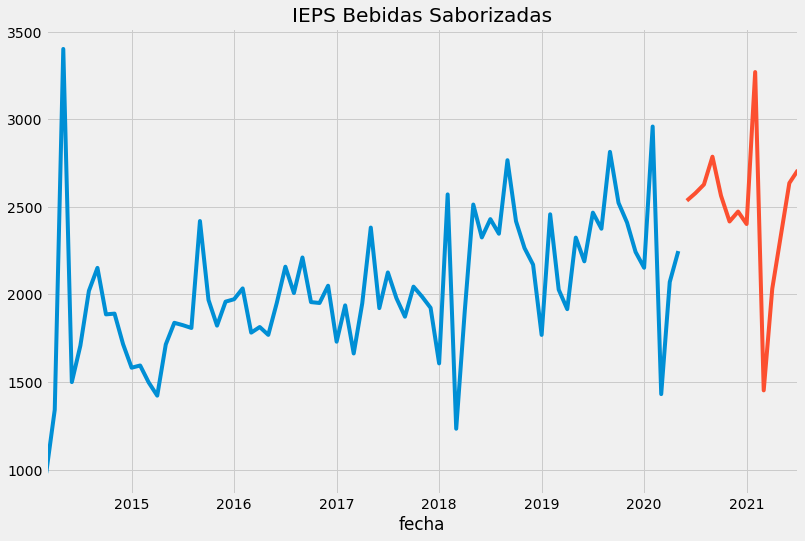

In [14]:
ieps_bebidassp=df['ieps_bebidassab']
ieps_bebidass=ieps_bebidassp.dropna()
train = ieps_bebidass[:int(0.85*(len(ieps_bebidass)))]
test = ieps_bebidass[int(0.85*(len(ieps_bebidass))):]
#plotting the data
train.plot()
test.plot()
plt.title('IEPS Bebidas Saborizadas')

In [ ]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter5 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter5, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IEPS Bebidas Saborizadas')
plt.show()

### 3.6 IEPS Alimentos

In [ ]:
ieps_alimentosp=df['ieps_alimentos']
ieps_alimentos=ieps_alimentosp.dropna()
ieps_alimentos = ieps_alimentos[(ieps_alimentos>0)]
train = ieps_alimentos[:int(0.85*(len(ieps_alimentos)))]
test = ieps_alimentos[int(0.85*(len(ieps_alimentos))):]
#plotting the data
train.plot()
test.plot()
plt.title('IEPS Alimentos')

In [ ]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter6 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter6, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IEPS Alimentos')
plt.show()

### 3.7 Impuesto a la Importación

Text(0.5, 1.0, 'Impuesto a la Importación')

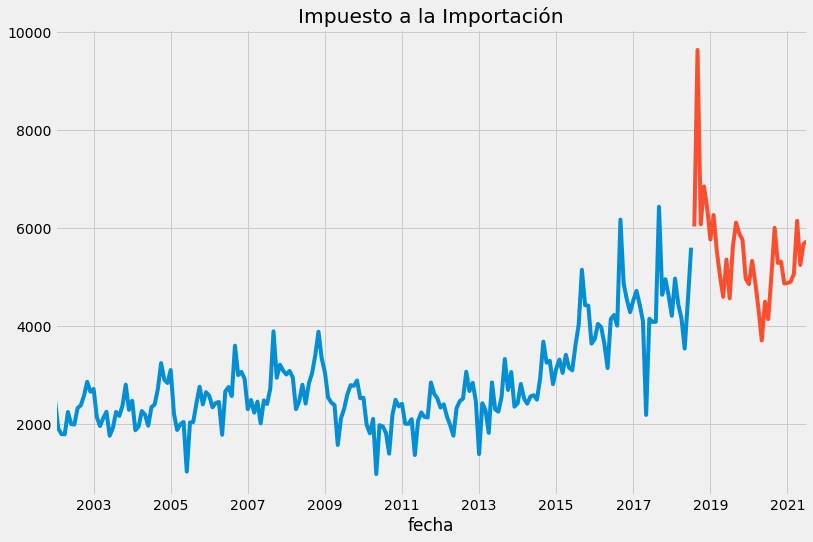

In [18]:
importacionp=df['importacion']
importacion=importacionp.dropna()
train = importacion[:int(0.85*(len(importacion)))]
test = importacion[int(0.85*(len(importacion))):]
#plotting the data
train.plot()
test.plot()
plt.title('Impuesto a la Importación')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


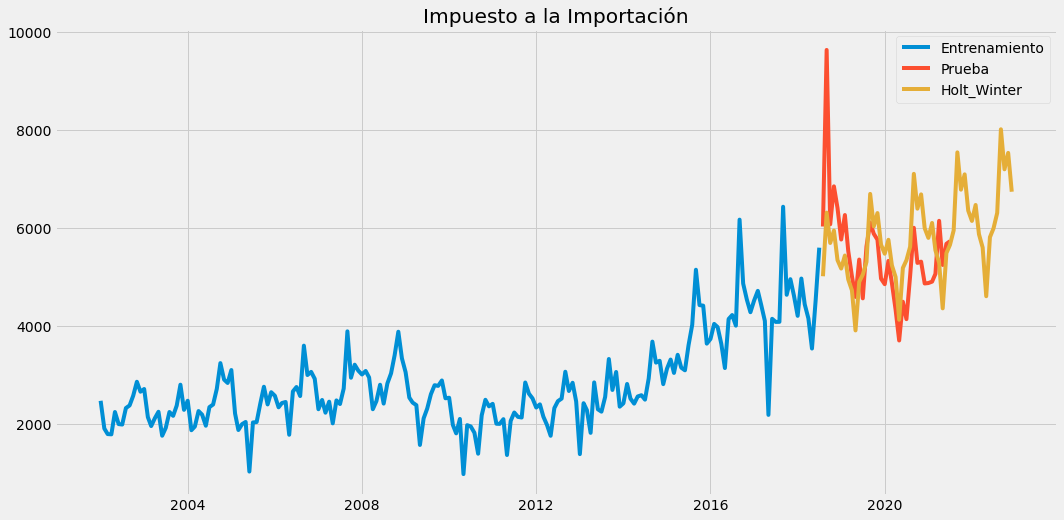

In [19]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter7 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter7, label='Holt_Winter')
plt.legend(loc='best')
plt.title('Impuesto a la Importación')
plt.show()

### 3.8 RFP Petroleors

Text(0.5, 1.0, 'RFP Petroleros')

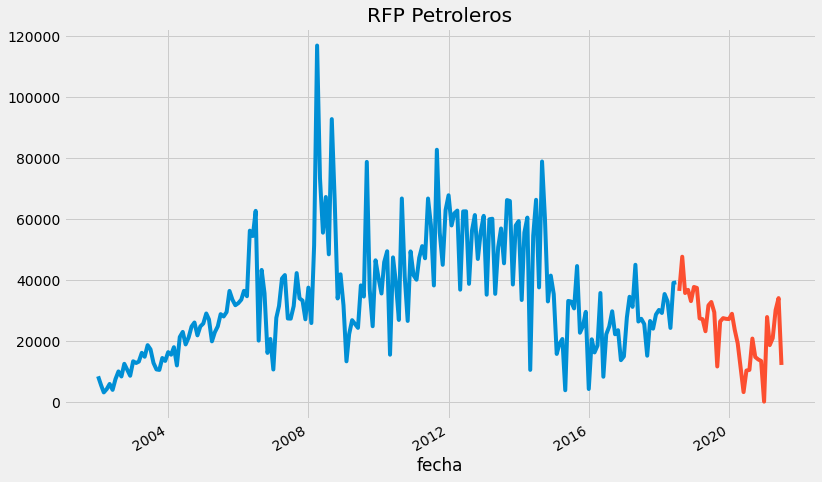

In [20]:
rfp_petrolerosp=df['rfp_petroleros']
rfp_petroleros=rfp_petrolerosp.dropna()
rfp_petroleros = rfp_petroleros[(rfp_petroleros>0)]
train = rfp_petroleros[:int(0.85*(len(rfp_petroleros)))]
test = rfp_petroleros[int(0.85*(len(rfp_petroleros))):]
#plotting the data
train.plot()
test.plot()
plt.title('RFP Petroleros')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


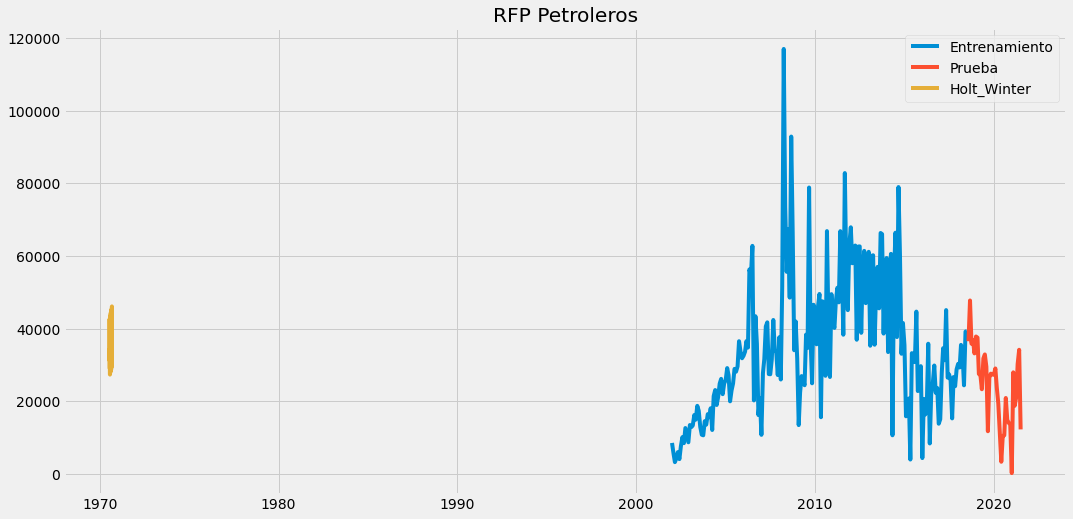

In [21]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winter8 = fit1.forecast(len(test)+17)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winter8, label='Holt_Winter')
plt.legend(loc='best')
plt.title('RFP Petroleros')
plt.show()

In [22]:
mensuales=pd.DataFrame({'ieps_cervezas': holt_winter1,
'ieps_gas': holt_winter2,
'ieps_tabacos': holt_winter3,
'ieps_bebidas': holt_winter4,
'ieps_bebidassab': holt_winter5,
'ieps_alimentos': holt_winter6,
'importacion': holt_winter7,
'rfp_petroleros': holt_winter8
})
mensuales.tail()

,ieps_cervezas,ieps_gas,ieps_tabacos,ieps_bebidas,ieps_bebidassab,ieps_alimentos,importacion,rfp_petroleros
2022-08-01,4609.561044,26559.117564,NaN,NaN,2684.117947,NaN,6316.466433,NaN
2022-09-01,5033.525228,28777.863656,NaN,NaN,2992.901895,NaN,8021.719211,NaN
2022-10-01,4577.236580,23523.473520,NaN,NaN,2730.630163,NaN,7205.708327,NaN
2022-11-01,4267.646216,27099.675567,NaN,NaN,2644.274123,NaN,7540.221695,NaN
2022-12-01,4275.078507,25750.478361,NaN,NaN,2596.178375,NaN,6748.032741,NaN


In [24]:
holt_winter1.to_csv('holt_winter1.csv')
holt_winter2.to_csv('holt_winter2.csv')
holt_winter3.to_csv('holt_winter3.csv')
holt_winter4.to_csv('holt_winter4.csv')
holt_winter5.to_csv('holt_winter5.csv')
holt_winter6.to_csv('holt_winter6.csv')
holt_winter7.to_csv('holt_winter7.csv')
holt_winter8.to_csv('holt_winter8.csv')
mensuales.to_csv('holt_winter_mensuales.csv')

## 4 Series Trimestrales

Para el caso de las series trimestrales, ISR e IVA, quise hacer una implementación directa de [esta publicación de Medium](https://towardsdatascience.com/time-series-forecasting-with-statistical-models-in-python-code-da457a46d68a) solamente agregando mis variables explicativas. Luego de leer la documentación no encontré como agregar las variables explicativas por lo que me quede con los resultados directos.

### 4.1 ISR

En el caso del ISR, decidí hacer 2 pronósticos directos, uno con series en términos reales:

In [25]:
df = pd.read_csv('202108trimestrales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

,ano,mes,dia,fechas,pib_real,pib_reale4,IPI,rfp_neta,isr,iva,rfp_real,isr_real,iva_real,tasa iva,reformaisr,covid,fecha
fecha,,,,,,,,,,,,,,,,,
2021-10-01,2021,10,1,2021/04,18725631,4681407.77,143.74,NaN,NaN,NaN,NaN,NaN,NaN,16,1,0,2021-10-01
2022-01-01,2022,1,1,2022/01 /r1,18021273,4505318.26,149.32,NaN,NaN,NaN,NaN,NaN,NaN,16,1,0,2022-01-01
2022-04-01,2022,4,1,2022/02,18331787,4582946.70,148.64,NaN,NaN,NaN,NaN,NaN,NaN,16,1,0,2022-04-01
2022-07-01,2022,7,1,2022/03,18308165,4577041.25,149.00,NaN,NaN,NaN,NaN,NaN,NaN,16,1,0,2022-07-01
2022-10-01,2022,10,1,2022/04,19118869,4779717.33,149.63,NaN,NaN,NaN,NaN,NaN,NaN,16,1,0,2022-10-01


Text(0.5, 1.0, 'ISR Real')

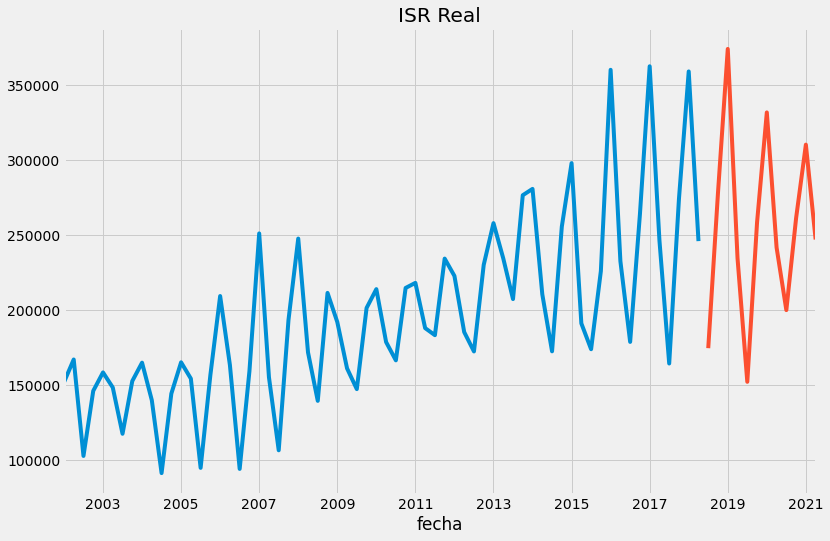

In [26]:
isrp=df['isr_real']
isr=isrp.dropna()
train = isr[:int(0.85*(len(isr)))]
test = isr[int(0.85*(len(isr))):]
train.plot()
test.plot()
plt.title('ISR Real')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


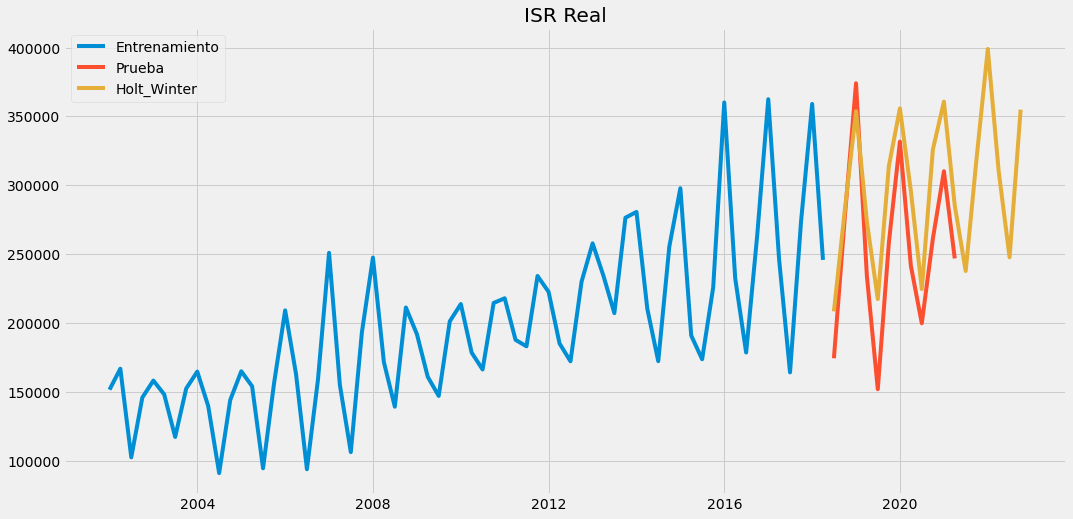

In [27]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winterA = fit1.forecast(len(test)+6)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winterA, label='Holt_Winter')
plt.legend(loc='best')
plt.title('ISR Real')
plt.show()

Text(0.5, 1.0, 'ISR Nominal')

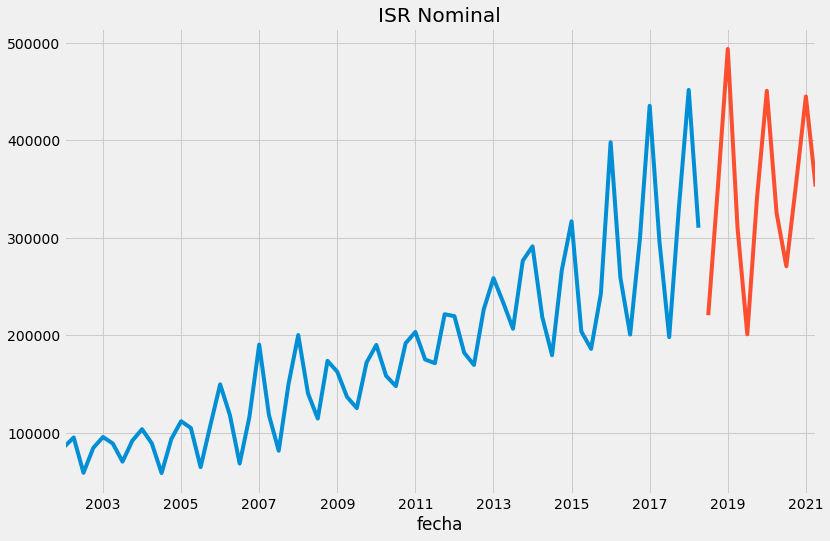

In [28]:
isrp=df['isr']
isr=isrp.dropna()
train = isr[:int(0.85*(len(isr)))]
test = isr[int(0.85*(len(isr))):]
train.plot()
test.plot()
plt.title('ISR Nominal')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


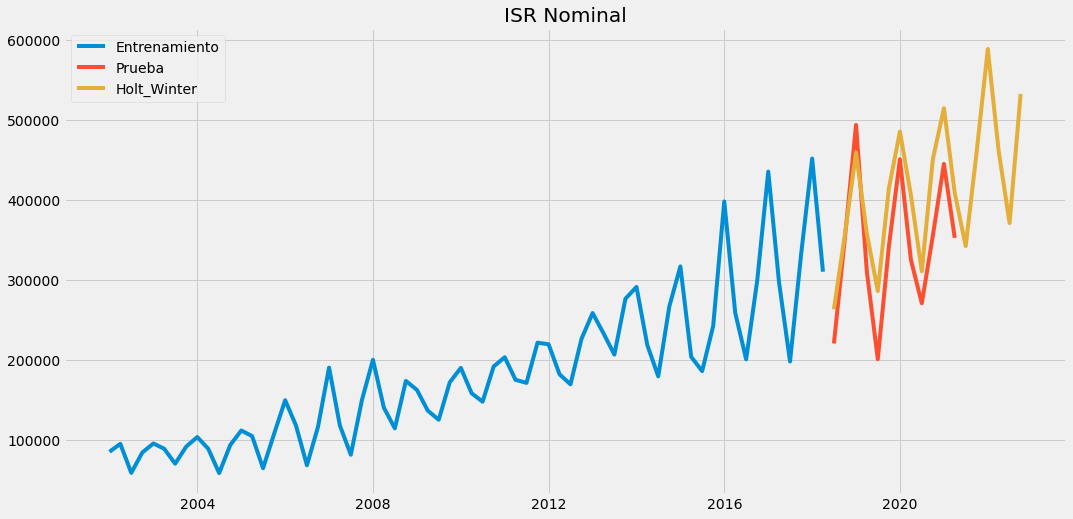

In [29]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winterB = fit1.forecast(len(test)+6)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winterB, label='Holt_Winter')
plt.legend(loc='best')
plt.title('ISR Nominal')
plt.show()

### 4.2 IVA

Text(0.5, 1.0, 'IVA Real')

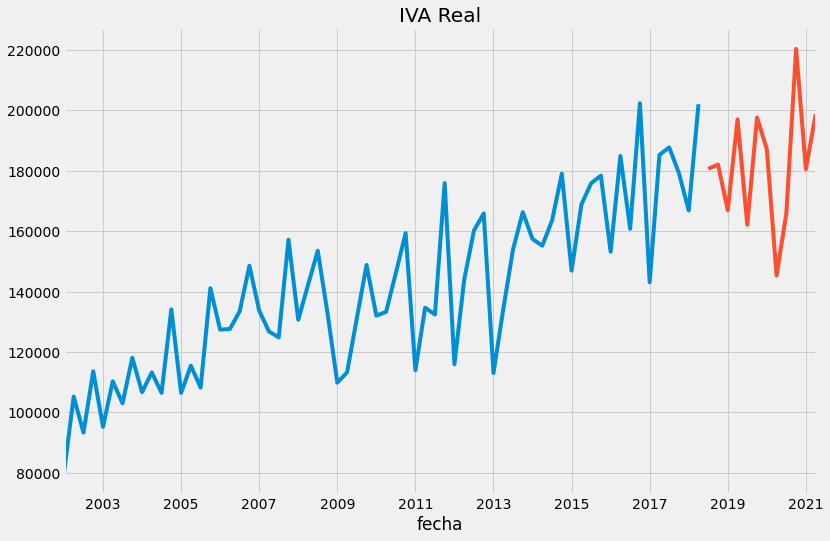

In [30]:
ivap=df['iva_real']
iva=ivap.dropna()
train = iva[:int(0.85*(len(iva)))]
test = iva[int(0.85*(len(iva))):]
train.plot()
test.plot()
plt.title('IVA Real')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


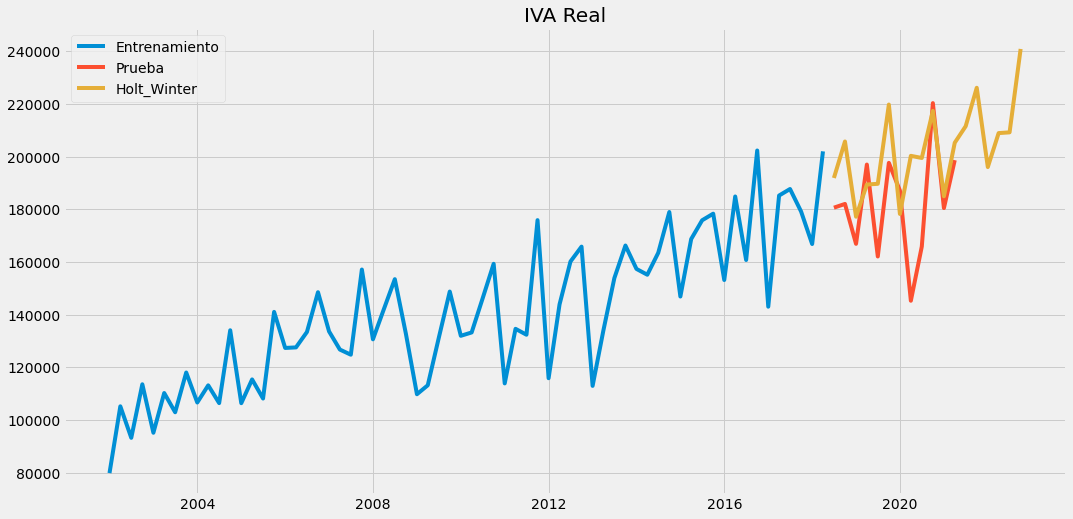

In [31]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winterC = fit1.forecast(len(test)+6)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winterC, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IVA Real')
plt.show()

Text(0.5, 1.0, 'IVA Nominal')

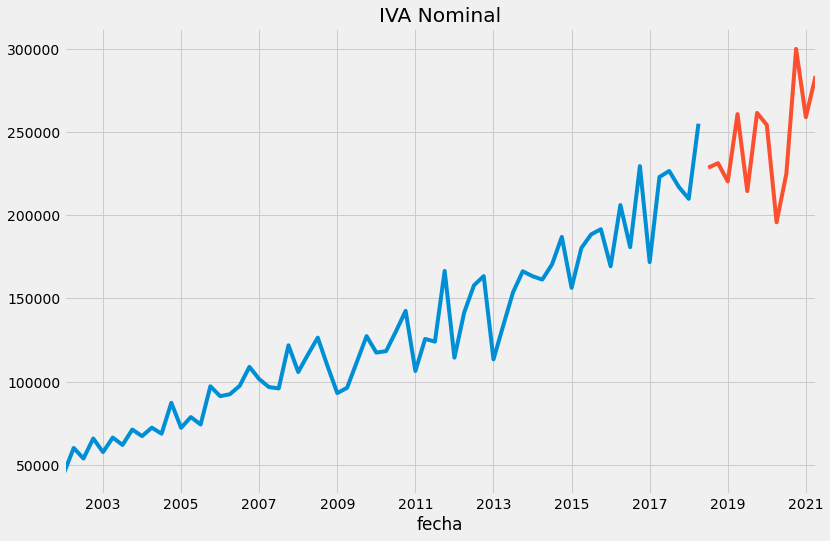

In [32]:
ivap=df['iva']
iva=ivap.dropna()
train = iva[:int(0.85*(len(iva)))]
test = iva[int(0.85*(len(iva))):]
train.plot()
test.plot()
plt.title('IVA Nominal')

C:\Users\Homar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


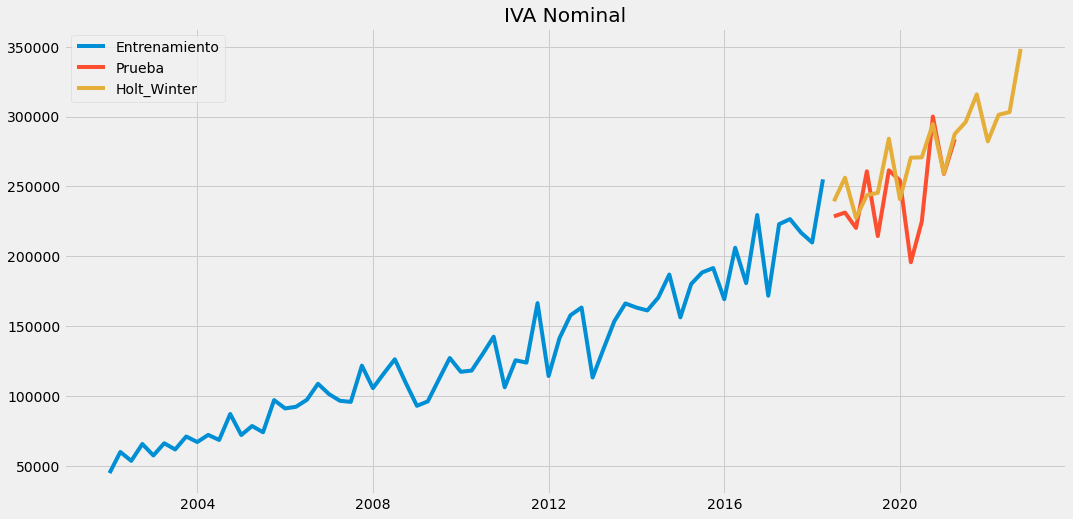

In [33]:
fit1 = ExponentialSmoothing(train ,seasonal_periods=12 ,trend='add', seasonal='add').fit(use_boxcox=True)
holt_winterD = fit1.forecast(len(test)+6)
plt.figure(figsize=(16,8))
plt.plot( train, label='Entrenamiento')
plt.plot(test, label='Prueba')
plt.plot(holt_winterD, label='Holt_Winter')
plt.legend(loc='best')
plt.title('IVA Nominal')
plt.show()

In [34]:
trimestrales=pd.DataFrame({'isr_real': holt_winterA,
'isr_nominal': holt_winterB,
'iva_real': holt_winterC,
'iva_nominal': holt_winterD
})
trimestrales.tail()

,isr_real,isr_nominal,iva_real,iva_nominal
2021-10-01,320856.634284,461085.004453,226223.287515,315819.396253
2022-01-01,398999.944458,588557.917276,196101.580467,282212.190055
2022-04-01,310526.396475,461406.667097,209009.377672,301246.402935
2022-07-01,247738.577530,371104.794835,209288.016302,303188.255105
2022-10-01,354925.592727,532339.586128,240964.598172,348327.269329


In [35]:
trimestrales.to_csv('holt_winter_trimestrales.csv')